(600, 8)
False
[]
Type          object
Cut           object
Clarity       object
Treatment     object
Hardness       int64
Carat        float64
Color         object
Price         object
dtype: object
Type          object
Cut           object
Clarity       object
Treatment     object
Hardness       int64
Carat        float64
Color         object
Price          int64
dtype: object
Number of nummerical features are 3
['Hardness', 'Carat', 'Price']
   Hardness  Carat   Price
0         8   2.58   75000
1         8   3.45   55500
2         8   1.75   25000
3         7   2.90   33000
4         7   4.12  122000
Unique values in Treatment column: ['Not Heated' 'Heated']
Treatment
Not Heated    312
Heated        288
Name: count, dtype: int64


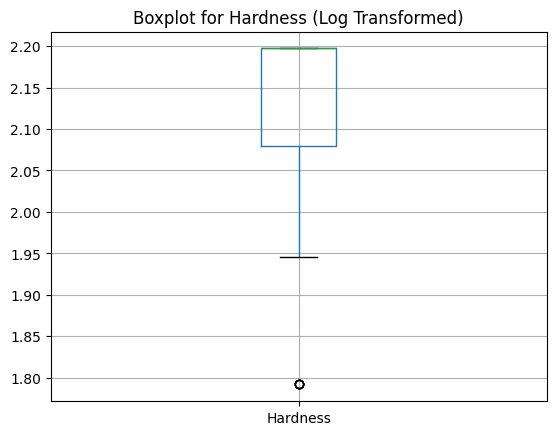

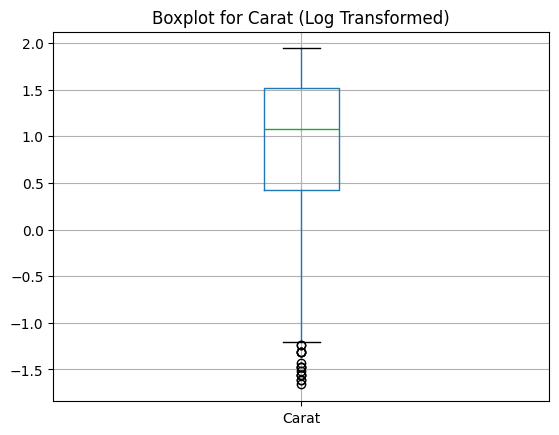

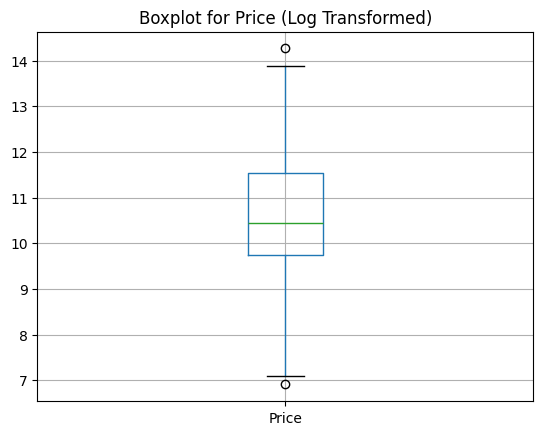

[]


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import joblib
from flask import Flask, request, jsonify

dataset = pd.read_csv('Gemstone_Dataset.csv')
dataset.head()
print(dataset.shape)

# check null values for features
features_with_na2 = []
typeHasNull = dataset['Type'].isnull().sum() >= 1
print(typeHasNull)
for feature in dataset.columns:
    if dataset[feature].isnull().sum() > 1:
        features_with_na2.append(feature)
print(features_with_na2)

def removeCommas(price):
    # Convert to string to handle mixed data types
    price_str = str(price)
    # Remove currency symbols and commas
    cleaned_price = price_str.replace('$', '').replace(',', '').strip()
    return cleaned_price


dataset["Price"] = dataset["Price"].apply(removeCommas)
print(dataset.dtypes)
dataset["Price"] = pd.to_numeric(dataset["Price"], errors="coerce")
print(dataset.dtypes)

features_with_na = [features for features in dataset.columns if dataset[features].isnull().sum() > 1]

numerical_features = [features for features in dataset.columns if dataset[features].dtype != 'O']
print("Number of nummerical features are", len(numerical_features))
print(numerical_features)
print(dataset[numerical_features].head())

categorical_features = [features for features in dataset.columns if dataset[features].dtype == 'O']

# plt.scatter(dataset["Hardness"],dataset["Price"])
# plt.xlabel("Hard")
# plt.ylabel("Price")
# plt.show()

# sns.boxplot(data=dataset["Price"])
# plt.show()

print("Unique values in Treatment column:", dataset["Treatment"].unique())
print(dataset["Treatment"].value_counts())
price_comparison = dataset.groupby("Treatment")["Price"].mean()
# print("\nAverage Price based on Treatment:\n", price_comparison)

for feature in numerical_features:
    data = dataset.copy()
    data[feature] = np.log(data[feature])  # Apply log transformation.
    data.boxplot(column=feature)  # Box plot for the feature.
    plt.title(f"Boxplot for {feature} (Log Transformed)")  # Add a title.
    plt.show()  # Display the box plot.


print(features_with_na)


In [43]:
###Null Values

print(dataset.isnull().sum())
print("Any NaN values?", dataset.isnull().values.any())
dataset["Price"] = dataset["Price"].apply(removeCommas)
dataset["Price"] = pd.to_numeric(dataset["Price"], errors="coerce")
print(dataset.dtypes)
print(dataset.head)

#numerical features
#This will get the median of particular feature data and fill for nan values
for feature in numerical_features:
    dataset[feature] = dataset[feature].fillna(dataset[feature].median())

#categorical features
#This will get the first data from particular feature and fill with that
for feature in categorical_features: 
    dataset[feature] = dataset[feature].fillna(dataset[feature].mode()[0])

Type         0
Cut          0
Clarity      0
Treatment    0
Hardness     0
Carat        0
Color        0
Price        0
dtype: int64
Any NaN values? False
Type          object
Cut           object
Clarity       object
Treatment     object
Hardness       int64
Carat        float64
Color         object
Price          int64
dtype: object
<bound method NDFrame.head of        Type      Cut Clarity   Treatment  Hardness  Carat   Color   Price
0    Spinel  Octagon     VS1  Not Heated         8   2.58   Green   75000
1    Spinel    Round    VVS2      Heated         8   3.45  Purple   55500
2    Spinel  Cushion      SI  Not Heated         8   1.75    Blue   25000
3    Spinel   Square     VS2  Not Heated         7   2.90  Yellow   33000
4    Spinel     Oval    VVS1      Heated         7   4.12   Green  122000
..      ...      ...     ...         ...       ...    ...     ...     ...
595    Ruby    Round      SI      Heated         9   2.33     Red   23000
596    Ruby  Cushion     VS2      Heated 

In [44]:
###Checking Outliers 

# def checkOutliers(feature):
#     q1_quantile = feature.quantile(0.25)
#     q3_quantile = feature.quantile(0.75)

#     iqr = q3_quantile - q1_quantile

#     lower_bound = q1_quantile - 1.5 * iqr
#     upper_bound = q3_quantile + 1.5 * iqr

#     return feature[(feature < lower_bound) | (feature > upper_bound)]

# data = dataset.copy()

# outliers = checkOutliers(data["Price"])
# print(outliers)

def remove_outliers(data, numeric_features):
    data_cleaned = data.copy()
    for feature in numeric_features:
        q1_quantile = data_cleaned[feature].quantile(0.25)
        q3_quantile = data_cleaned[feature].quantile(0.75)
        iqr = q3_quantile - q1_quantile
        lower_bound = q1_quantile - 1.5 * iqr
        upper_bound = q3_quantile + 1.5 * iqr
        
        # Filter rows within bounds for this feature
        data_cleaned = data_cleaned[(data_cleaned[feature] >= lower_bound) & (data_cleaned[feature] <= upper_bound)]
    return data_cleaned

# dataset = remove_outliers(dataset, numerical_features)

# print(f"Original dataset shape: {dataset.shape}")
# print(f"Cleaned dataset shape: {cleaned_data.shape}")

In [45]:
### Encoding Categrical features

#print(categorical_features)

# for feature in categorical_features: 
#     print('category type is {} and number of categories are {}'.format(feature, dataset[feature].unique()))

#below code shows how the categoriacl data relate with the price
# for feature in categorical_features:
#     data = dataset.copy()
#     data.groupby(feature)['Price'].median().plot.bar()
#     plt.xlabel(feature)
#     plt.ylabel('Price')
#     plt.show()


# label_encoder = LabelEncoder() #lable encoding which gives lower accuracy than one hot encoding
# for feature in categorical_features:
#     datasetCopy[feature] = label_encoder.fit_transform(datasetCopy[feature])
# Transform categorical features

# encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
# encoder.fit(datasetCopy[categorical_features])

# encoded_array = encoder.transform(datasetCopy[categorical_features])

# # Convert to DataFrame
# encoded_columns = encoder.get_feature_names_out().tolist()
# encoded_df = pd.DataFrame(encoded_array, columns=encoded_columns)

# # Drop original categorical columns and add transformed ones
# datasetCopy = datasetCopy.drop(columns=categorical_features)
# datasetCopy = pd.concat([datasetCopy, encoded_df], axis=1)



# if hasattr(model, 'feature_importances_'):
#     feature_importance = pd.DataFrame(
#         {'Feature': model.feature_names_in_, 'Importance': model.feature_importances_}
#     ).sort_values(by="Importance", ascending=False)
#     print(feature_importance)
# else:
#     print("Feature importance not available for this model type.")


        # Ensure same encoded feature columns exist as in training
        # all_columns = joblib.load("feature_columns.pkl")  # Load feature names used in training
        # df = df.reindex(columns=all_columns, fill_value=0)  # Ensure feature consistency

In [46]:
datasetCopy = dataset.copy()
datasetCopy[categorical_features] = datasetCopy[categorical_features].fillna("Unknown")
datasetCopy = pd.get_dummies(datasetCopy, columns=categorical_features, drop_first=True)
# print("Unique treatment encoding:\n ", datasetCopy.filter(like="Treatment"))
# print(datasetCopy.filter(like="Treatment").head())


#print(datasetCopy)
feature_subtypes = {feature: dataset[feature].unique().tolist() for feature in categorical_features}
print(feature_subtypes)


{'Type': ['Spinel', 'Alexandrite', 'Chrysoberyl', 'Sapphire', 'Tomalin', 'Ruby'], 'Cut': ['Octagon', 'Round', 'Cushion', 'Square', 'Oval'], 'Clarity': ['VS1', 'VVS2', 'SI', 'VS2', 'VVS1'], 'Treatment': ['Not Heated', 'Heated'], 'Color': ['Green', 'Purple', 'Blue', 'Yellow', 'Orange', 'Red', 'Pink', 'Brown', 'Teal']}


In [47]:
### Train-Test split
x = datasetCopy.drop("Price", axis=1)
y = datasetCopy["Price"]

# print(x.head())
print(y.head())
### Model training
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.14, random_state=42)

# scaler = MinMaxScaler(feature_range=(0,1))

### Feature scalling
train_numerical_features = ["Hardness", "Carat"] 
scaler = StandardScaler()
x_train[train_numerical_features] = scaler.fit_transform(x_train[train_numerical_features])
x_test[train_numerical_features] = scaler.transform(x_test[train_numerical_features])

linear_model = LinearRegression()
linear_model.fit(x_train,y_train)

rf_model = RandomForestRegressor(n_estimators=80, random_state=30)
rf_model.fit(x_train, y_train)

svr_model = SVR(kernel='rbf')  # linear and poly kernerls also there
svr_model.fit(x_train, y_train)

0     75000
1     55500
2     25000
3     33000
4    122000
Name: Price, dtype: int64


SVR()

In [48]:
from sklearn.metrics import accuracy_score
### Model Evaluation 
y_pred = linear_model.predict(x_test)
y_pred_rf = rf_model.predict(x_test)
y_pred_svr = svr_model.predict(x_test)

# Evaluate SVR model
r2_svr = r2_score(y_test, y_pred_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
mse_svr = mean_squared_error(y_test, y_pred_svr)
print("SVM R²: ", r2_svr)
print("SVM MAE: ", mae_svr)
print("SVM MSE: ", mse_svr)

# Evaluate Random Forest model
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print("Random Forest R²: ", r2_rf)
print("Random Forest MAE: ", mae_rf)
print("Random Forest MSE: ", mse_rf)

# Evaluate Linear Regression model
r2_lr = r2_score(y_test, y_pred)
mae_lr = mean_absolute_error(y_test, y_pred)
mse_lr = mean_squared_error(y_test, y_pred)
print("Linear Regression R²: ", r2_lr)
print("Linear Regression MAE: ", mae_lr)
print("Linear Regression MSE: ", mse_lr)

feature_importance = pd.DataFrame(
    {'Feature': rf_model.feature_names_in_, 'Importance': rf_model.feature_importances_}
).sort_values(by="Importance", ascending=False)
print(feature_importance)



SVM R²:  -0.1575343598280452
SVM MAE:  73669.03382414009
SVM MSE:  25774192603.380993
Random Forest R²:  0.8167729334664575
Random Forest MAE:  39908.44534313725
Random Forest MSE:  4079818160.8099923
Linear Regression R²:  0.5514038967472998
Linear Regression MAE:  64016.40460923189
Linear Regression MSE:  9988647220.872887
                 Feature  Importance
1                  Carat    0.358195
13          Clarity_VVS1    0.163533
4          Type_Sapphire    0.155803
0               Hardness    0.068940
7            Cut_Octagon    0.050055
11           Clarity_VS1    0.028644
8               Cut_Oval    0.028165
15  Treatment_Not Heated    0.019101
3              Type_Ruby    0.015612
14          Clarity_VVS2    0.014339
22            Color_Teal    0.013132
17           Color_Green    0.010719
9              Cut_Round    0.009065
2       Type_Chrysoberyl    0.008525
6           Type_Tomalin    0.008009
16           Color_Brown    0.007788
21             Color_Red    0.006952
23     

In [49]:
joblib.dump(rf_model, 'gemstone_price_model.pkl')

scaler_filename = "scaler.pkl"
joblib.dump(scaler, scaler_filename)

# Save the one-hot encoder if categorical features were one-hot encoded
encoder_filename = "encoder.pkl"
joblib.dump(categorical_features, encoder_filename) 

['encoder.pkl']

In [ ]:
app = Flask(__name__)

# Load the trained model
model = joblib.load("gemstone_price_model.pkl")
scaler = joblib.load("scaler.pkl")
categorical_features = joblib.load("encoder.pkl")
expected_features = model.feature_names_in_.tolist()

@app.route('/predict', methods=['POST'])
def predict():
    try:
        data = request.get_json()
        df = pd.DataFrame([data])  # Convert JSON to DataFrame

        # Ensure feature order matches training data
        # expected_features = ["Type", "Cut", "Clarity", "Treatment", "Carat", "Color"]  # Include all features used in training
        df = df.reindex(columns=expected_features, fill_value=0)

        # Apply One-Hot Encoding to categorical features
        df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

        # Apply Scaling
        numerical_features = ["Hardness", "Carat"]
        df[numerical_features] = scaler.transform(df[numerical_features])

        # Predict price
        prediction = model.predict(df)[0]
        return jsonify({'predicted_price': prediction})

    except Exception as e:
        return jsonify({'error': str(e)})

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5002, debug=True)



 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5002
 * Running on http://192.168.8.129:5002
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1

In [104]:
new_entry = {
    "Type": "Spinal",
    "Cut": "Round",
    "Clarity": "VVS2",
    "Treatment": "Not Heated",
    "Hardness": 7,
    "Carat": 5,
    "Color": "Purple"
}

new_entry_df = pd.DataFrame([new_entry])
new_entry_df = pd.get_dummies(new_entry_df, columns=categorical_features, drop_first=True)
new_entry_df = new_entry_df.reindex(columns=x_train.columns, fill_value=0)
new_entry_df[train_numerical_features] = scaler.transform(new_entry_df[train_numerical_features])

lr_prediction = linear_model.predict(new_entry_df)
print(f"Linear Regression Prediction: {lr_prediction[0]}")

# Predict using Random Forest
rf_prediction = rf_model.predict(new_entry_df)
print(f"Random Forest Prediction: {rf_prediction[0]}")

# Predict using SVM
svr_prediction = svr_model.predict(new_entry_df)
print(f"SVM Prediction: {svr_prediction[0]}")

Linear Regression Prediction: 204715.22822183926
Random Forest Prediction: 20359.75
SVM Prediction: 34003.21115600011
